In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import fitz

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

from pprint import pprint

import util

In [2]:
test_files_dir = "./test_files/"
test_files = util.list_files(test_files_dir)
test_files

['./test_files/LS_index_1937.pdf',
 './test_files/Argentinia_LS_index_1934_test_I_DE.pdf',
 './test_files/LS_index_1976.pdf',
 './test_files/LS_index_1944.pdf',
 './test_files/LS_index_1986.pdf',
 './test_files/LS_Index_1983.pdf',
 './test_files/LS_index_1944_split.pdf']

In [171]:
pages, dicts = util.read_pdf(test_files[6])

Reading pdf from ./test_files/LS_index_1944_split.pdf
...
Finished reading 6 page(s)


In [172]:
page_b = dicts[3]["blocks"]
page_lines = []
lines_bbox = []

for p in dicts:
    for b in p["blocks"]:
        for l in b["lines"]:
            line = []
            bbox = l["bbox"]
            for s in l["spans"]:
                line.append(s["text"])

            page_lines.append(line)
            lines_bbox.append(bbox)

In [173]:
d = 2
lines_df = pd.DataFrame({
    "line_text": page_lines, 
    "x0": [round(b[0], d) for b in lines_bbox],
    "y0": [round(b[1], d) for b in lines_bbox],
    "x1": [round(b[2], d) for b in lines_bbox],
    "y1": [round(b[3], d) for b in lines_bbox],
})

lines_df

,line_text,x0,y0,x1,y1
0,[1944—Indexes I],47.0,48.06,103.22,56.46
1,[—],194.0,49.11,202.20,57.31
2,[4],206.0,50.25,209.61,56.75
3,[—],214.0,49.34,221.90,57.24
4,[Queensland],49.0,66.06,102.92,76.06
...,...,...,...,...,...
703,[Argentina.],230.0,550.94,269.09,560.14
704,"[4L.S. 1929 (Arg. 1, A); 1930 (Arg.]",73.0,572.39,221.68,582.99
705,"[1, A). —]",228.0,572.46,265.33,582.96
706,[1930 (Arg. 3. B).],296.0,573.09,366.26,583.29


In [174]:
lines_df["dy"] = lines_df["y0"].diff(periods=1).abs()
lines_df["line_no"] = lines_df["dy"].gt(4).cumsum()

lines_df

,line_text,x0,y0,x1,y1,dy,line_no
0,[1944—Indexes I],47.0,48.06,103.22,56.46,NaN,0
1,[—],194.0,49.11,202.20,57.31,1.05,0
2,[4],206.0,50.25,209.61,56.75,1.14,0
3,[—],214.0,49.34,221.90,57.24,0.91,0
4,[Queensland],49.0,66.06,102.92,76.06,16.72,1
...,...,...,...,...,...,...,...
703,[Argentina.],230.0,550.94,269.09,560.14,0.55,331
704,"[4L.S. 1929 (Arg. 1, A); 1930 (Arg.]",73.0,572.39,221.68,582.99,21.45,332
705,"[1, A). —]",228.0,572.46,265.33,582.96,0.07,332
706,[1930 (Arg. 3. B).],296.0,573.09,366.26,583.29,0.63,332


In [315]:
# Grouping found lines that are close together to get the real lines

lines = []
line_spans = []
x0 = []
y0 = []
x1 = []
y1 = []

for l in lines_df.groupby("line_no"):
    line = []
    for r in l[1].iterrows():
        line.append(r[1]["line_text"])
        
    lines.append(" ".join(util.flatten(line)))
    line_spans.append(util.flatten(line))
    
    x0.append(l[1]["x0"].min())
    y0.append(l[1]["y0"].min())
    x1.append(l[1]["x1"].max())
    y1.append(l[1]["y1"].max()) 

blines_df = pd.DataFrame({
    "line_text": lines,
    "spans": line_spans,
    "x0": x0,
    "y0": y0,
    "x1": x1,
    "y1": y1,
})

In [316]:
# Removing lines with no real content (no word characters, no numbers)

dumb_lines = []
for row in blines_df.iterrows():
    if not re.search("[a-zA-Z0-9]", row[1]["line_text"]):
        dumb_lines.append(row[0])

blines_df = blines_df.drop(dumb_lines)
blines_df

,line_text,spans,x0,y0,x1,y1
0,1944—Indexes I — 4 —,"[1944—Indexes I, —, 4, —]",47.0,48.06,221.90,57.31
1,Queensland,[Queensland],49.0,66.06,102.92,76.06
2,Dec. 1 An Act to suspend certain provisions of...,"[Dec. 1, An Act to suspend certain provisions ...",58.0,82.71,364.39,93.01
3,"Insurance Acts, 1922 to 19368, and for purpose...","[Insurance Acts, 1922 to 19368, and for purpos...",105.0,90.69,365.77,100.39
4,"8 Geo. VI, No. 14. The Unemployed Workers Insu...","[8 Geo. VI, No. 14., The Unemployed Workers In...",105.0,98.59,365.53,109.34
...,...,...,...,...,...,...
329,"the national territory. (B.O. 18th December, 1...","[the national, territory., (B.O., 18th Decembe...",121.0,524.04,381.10,534.04
330,pp. 20-22) Arg. 2 (A),"[pp. 20-22), Arg. 2 (A)]",120.0,532.39,379.77,542.59
331,B.O. = Boletin Of icial de Ia Argentina.,"[B.O. =, Boletin, Of icial de Ia, Argentina.]",74.0,549.91,269.09,560.61
332,"4L.S. 1929 (Arg. 1, A); 1930 (Arg. 1, A). — 19...","[4L.S. 1929 (Arg. 1, A); 1930 (Arg., 1, A). —,...",73.0,572.39,366.26,583.29


In [363]:
# Kmeans clustering with x0 (start of line) and x1 (end of line)

X0 = blines_df["x0"].to_numpy()
X0 = [[e] for e in X0]

kmeans0 = KMeans(n_clusters=2).fit(X0)

X1 = blines_df["x1"].to_numpy()
X1 = [[e] for e in X1]

kmeans1 = KMeans(n_clusters=3).fit(X1)

In [319]:
blines_df["label_kmeans_0"] = kmeans0.labels_
blines_df["label_kmeans_1"] = kmeans1.labels_
blines_df.loc[blines_df["label_kmeans_0"]==0]
blines_df

,line_text,spans,x0,y0,x1,y1,label_kmeans_0,label_kmeans_1
0,1944—Indexes I — 4 —,"[1944—Indexes I, —, 4, —]",47.0,48.06,221.90,57.31,0,2
1,Queensland,[Queensland],49.0,66.06,102.92,76.06,0,1
2,Dec. 1 An Act to suspend certain provisions of...,"[Dec. 1, An Act to suspend certain provisions ...",58.0,82.71,364.39,93.01,0,0
3,"Insurance Acts, 1922 to 19368, and for purpose...","[Insurance Acts, 1922 to 19368, and for purpos...",105.0,90.69,365.77,100.39,1,0
4,"8 Geo. VI, No. 14. The Unemployed Workers Insu...","[8 Geo. VI, No. 14., The Unemployed Workers In...",105.0,98.59,365.53,109.34,1,0
...,...,...,...,...,...,...,...,...
329,"the national territory. (B.O. 18th December, 1...","[the national, territory., (B.O., 18th Decembe...",121.0,524.04,381.10,534.04,1,0
330,pp. 20-22) Arg. 2 (A),"[pp. 20-22), Arg. 2 (A)]",120.0,532.39,379.77,542.59,1,0
331,B.O. = Boletin Of icial de Ia Argentina.,"[B.O. =, Boletin, Of icial de Ia, Argentina.]",74.0,549.91,269.09,560.61,0,2
332,"4L.S. 1929 (Arg. 1, A); 1930 (Arg. 1, A). — 19...","[4L.S. 1929 (Arg. 1, A); 1930 (Arg., 1, A). —,...",73.0,572.39,366.26,583.29,0,0


In [360]:
clusters_x0 = util.flatten(kmeans0.cluster_centers_)
clusters_x1 = util.flatten(kmeans1.cluster_centers_)

cl_x0 = pd.DataFrame({"clusters_x0": clusters_x0}).reset_index().sort_values(by="clusters_x0").reset_index(drop=True).rename(columns={"index": "label"})
cl_x1 = pd.DataFrame({"clusters_x1": clusters_x1}).reset_index().sort_values(by="clusters_x1").reset_index(drop=True).rename(columns={"index": "label"})

display(cl_x0)
display(cl_x1)

,label,clusters_x0
0,0,64.423611
1,1,125.304598


,label,clusters_x1
0,1,138.147234
1,2,239.869020
2,0,369.642636


In [353]:
labels_meaning = []
labels_meaning.append((int(cl_x0.iloc[0]["label"]), int(cl_x1.iloc[0]["label"]), "country"))
labels_meaning.append((int(cl_x0.iloc[0]["label"]), int(cl_x1.iloc[2]["label"]), "start"))
labels_meaning.append((int(cl_x0.iloc[1]["label"]), int(cl_x1.iloc[2]["label"]), "middle"))
labels_meaning.append((int(cl_x0.iloc[1]["label"]), int(cl_x1.iloc[1]["label"]), "end"))

blines_df["label"] = "other"

for l in labels_meaning:
    blines_df.loc[(blines_df["label_kmeans_0"]==l[0]) & (blines_df["label_kmeans_1"]==l[1]), "label"] = l[2]

blines_df

,line_text,spans,x0,y0,x1,y1,label_kmeans_0,label_kmeans_1,label
0,1944—Indexes I — 4 —,"[1944—Indexes I, —, 4, —]",47.0,48.06,221.90,57.31,0,2,other
1,Queensland,[Queensland],49.0,66.06,102.92,76.06,0,1,country
2,Dec. 1 An Act to suspend certain provisions of...,"[Dec. 1, An Act to suspend certain provisions ...",58.0,82.71,364.39,93.01,0,0,start
3,"Insurance Acts, 1922 to 19368, and for purpose...","[Insurance Acts, 1922 to 19368, and for purpos...",105.0,90.69,365.77,100.39,1,0,middle
4,"8 Geo. VI, No. 14. The Unemployed Workers Insu...","[8 Geo. VI, No. 14., The Unemployed Workers In...",105.0,98.59,365.53,109.34,1,0,middle
...,...,...,...,...,...,...,...,...,...
329,"the national territory. (B.O. 18th December, 1...","[the national, territory., (B.O., 18th Decembe...",121.0,524.04,381.10,534.04,1,0,middle
330,pp. 20-22) Arg. 2 (A),"[pp. 20-22), Arg. 2 (A)]",120.0,532.39,379.77,542.59,1,0,middle
331,B.O. = Boletin Of icial de Ia Argentina.,"[B.O. =, Boletin, Of icial de Ia, Argentina.]",74.0,549.91,269.09,560.61,0,2,other
332,"4L.S. 1929 (Arg. 1, A); 1930 (Arg. 1, A). — 19...","[4L.S. 1929 (Arg. 1, A); 1930 (Arg., 1, A). —,...",73.0,572.39,366.26,583.29,0,0,start


In [367]:
blines_df.loc[blines_df["label"] == "country"]

,line_text,spans,x0,y0,x1,y1,label_kmeans_0,label_kmeans_1,label
1,Queensland,[Queensland],49.0,66.06,102.92,76.06,0,1,country
16,South Australia,[South Australia],50.0,215.79,125.62,227.89,0,1,country
20,Tasmania,[Tasmania],50.0,265.94,96.27,277.84,0,1,country
26,BELGIUM,[BELGIUM],50.0,320.04,102.38,331.54,0,1,country
30,BOLIVIA,[BOLIVIA],51.0,367.81,97.86,379.21,0,1,country
45,"and 7 Geo. VI, No. 9 and No. 37).","[and 7 Geo. VI, No. 9 and No. 37).]",51.0,513.64,186.00,523.53,0,1,country
55,FiNLAND (continued),[FiNLAND (continued)],52.0,71.91,164.15,84.11,0,1,country
70,FRANCE,[FRANCE],53.0,235.24,98.37,246.74,0,1,country
89,"December 2, pp. 39-40 below.","[December 2, pp. 39-40 below.]",63.0,431.06,179.51,440.66,0,1,country
104,INDIA (continued),"[INDIA, (continued)]",66.0,67.50,158.48,80.22,0,1,country


In [352]:
blines_df.to_csv("first_labeling.csv")

In [362]:
blines_df_2 = blines_df.copy().loc[blines_df["label_kmeans_0"]==cl_x0.iloc[0]["label"]]
X0_2 = blines_df_2["x0"].to_numpy()
X0_2 = [[e] for e in X0_2]

kmeans0_2 = KMeans(n_clusters=2).fit(X0_2)

In [326]:
blines_df_2["label_kmeans_0_2"] = kmeans0_2.labels_
blines_df_2.loc[blines_df_2["label_kmeans_0_2"]==0]

,line_text,spans,x0,y0,x1,y1,label_kmeans_0,label_kmeans_1,label,label_kmeans_0_2
0,1944—Indexes I — 4 —,"[1944—Indexes I, —, 4, —]",47.0,48.06,221.90,57.31,0,2,other,0
1,Queensland,[Queensland],49.0,66.06,102.92,76.06,0,1,other,0
2,Dec. 1 An Act to suspend certain provisions of...,"[Dec. 1, An Act to suspend certain provisions ...",58.0,82.71,364.39,93.01,0,0,other,0
6,Dec. 14 An Act to amend the Workers' Compensat...,"[Dec. 14, An Act to amend the Workers' Compens...",58.0,121.11,364.94,131.34,0,0,other,0
10,"Dec. 14 An Act to provide that persons who, du...","[Dec. 14, An Act to provide, that persons who,...",58.0,158.34,364.94,169.74,0,0,other,0
...,...,...,...,...,...,...,...,...,...,...
249,Mauritius,[Mauritius],60.0,329.33,105.89,341.13,0,1,other,0
254,UNITED STATES OF AMERICA,"[UNITED, STATES OF AMERICA]",60.0,374.77,227.66,386.73,0,2,other,0
264,URUGUAY,[URUGUAY],60.0,460.45,115.49,471.55,0,1,other,0
274,"""-L.S. 1937 (Lee. 1). — L.S. 1934 (Maur. 2).","[""-L.S., 1937 (Lee. 1). —, L.S., 1934 (Maur. 2).]",60.0,566.96,245.15,576.93,0,2,other,0


<AxesSubplot:xlabel='label_kmeans_0', ylabel='x0'>

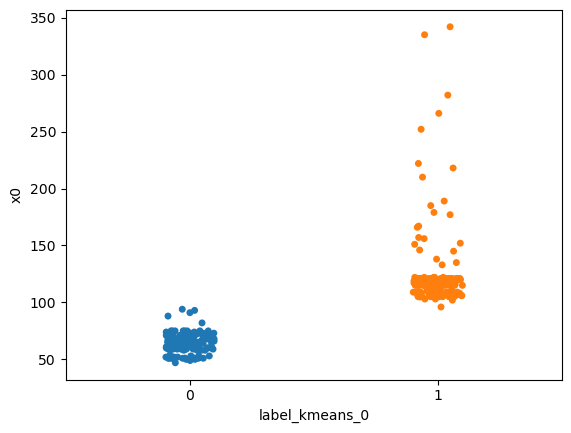

In [327]:
sns.stripplot(data=blines_df, y = "x0", x = "label_kmeans_0")

<AxesSubplot:xlabel='label_kmeans_0_2', ylabel='x0'>

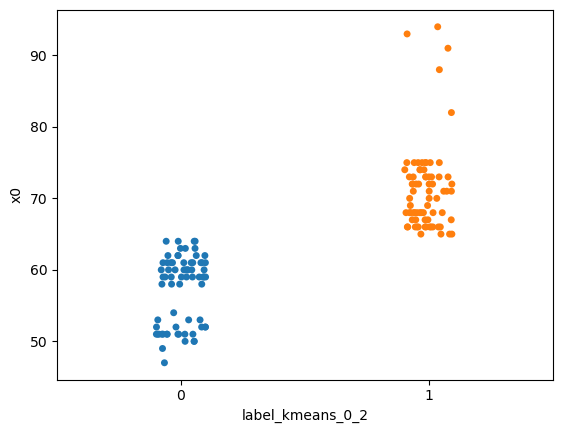

In [328]:
sns.stripplot(data=blines_df_2, y = "x0", x = "label_kmeans_0_2")

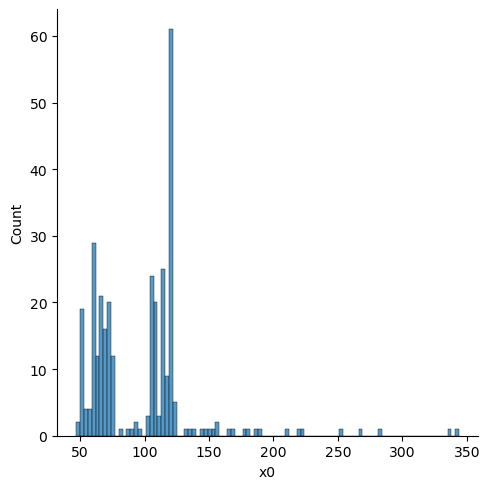

In [303]:
sns.displot(data=blines_df, x = "x0", binwidth=3)

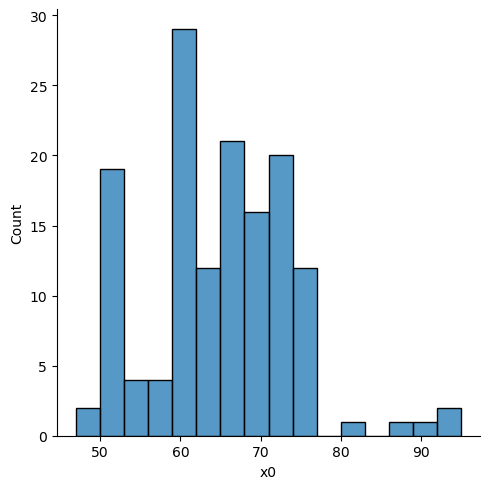

In [329]:
sns.displot(data=blines_df_2, x = "x0", binwidth=3)

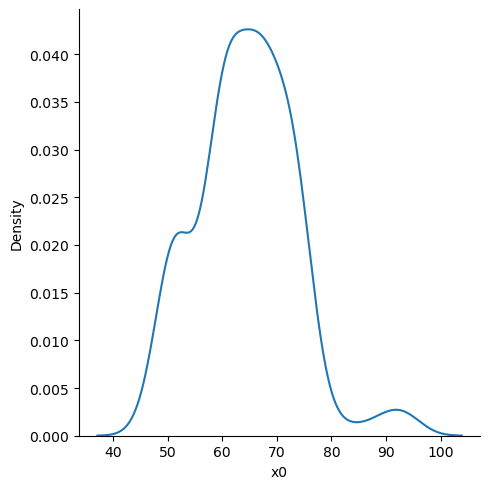

In [273]:
sns.displot(data=blines_df_2, x = "x0", kind="kde")

<AxesSubplot:xlabel='label_kmeans_1', ylabel='x1'>

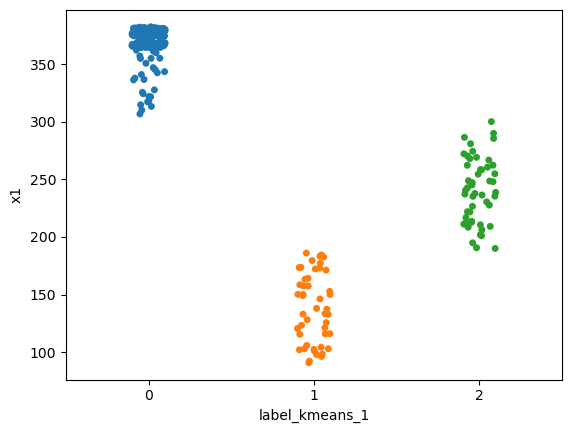

In [330]:
sns.stripplot(data=blines_df, y = "x1", x = "label_kmeans_1")

In [16]:
dicts[3]["blocks"]

[{'number': 0,
  'type': 0,
  'bbox': (47.0, 48.0600471496582, 221.89999389648438, 57.31000900268555),
  'lines': [{'spans': [{'size': 8.399999618530273,
      'flags': 4,
      'font': 'Times-Roman',
      'color': 0,
      'ascender': 0.75,
      'descender': -0.25,
      'text': '1944—Indexes I',
      'origin': (47.0, 54.36004638671875),
      'bbox': (47.0,
       48.0600471496582,
       103.22126007080078,
       56.460044860839844)}],
    'wmode': 0,
    'dir': (1.0, 0.0),
    'bbox': (47.0, 48.0600471496582, 103.22126007080078, 56.460044860839844)},
   {'spans': [{'size': 8.199999809265137,
      'flags': 4,
      'font': 'Times-Roman',
      'color': 0,
      'ascender': 0.75,
      'descender': -0.25,
      'text': '—',
      'origin': (194.0, 55.260009765625),
      'bbox': (194.0,
       49.110008239746094,
       202.1999969482422,
       57.31000900268555)}],
    'wmode': 0,
    'dir': (1.0, 0.0),
    'bbox': (194.0, 49.110008239746094, 202.1999969482422, 57.310009002685

In [15]:
print(pages[3])

1944—Indexes I
— 4 —
Queensland
Dec. 1
An Act to suspend certain provisions of the Unemployed Workers
Insurance Acts, 1922 to 19368, and for purposes incidental thereto.
8 Geo. VI, No. 14.
The Unemployed Workers Insurance Acts
Amendment Act of 1944.
Dec. 14
An Act to amend the Workers' Compensation Acts, 1916 to 1943',
in certain particulars [compensation for certain diseases and liability
for hospital and medical treatmenti.
9 Geo. VI, No. 2.
The
Workers' Compensation Acts Amendment Act of 194&
Dec. 14
An Act to provide that persons who, during war, have been
members of fighting forces shall receive preference in employment,
and to amend The Industrial Conciliation and Arbitration Acts,
1932 to
194210, in certain particulars.
9 Geo. VI, No. 4.
The
Industrial Conciliation and Arbitration Acts (War Preference in
Employment) Act of 1944.
South Australia
Dec. 14
An Act to amend the Workmen's Compensation Act,
No. 33 of 1944.
Workmen's Compensation Act Amendment Act,
1944.
Tasmania
Apr. 27

## Probleme
- Dokumente mit 2 Spalten
- Dokumente mit Länder-Überschrift über ganze Breite der Seite

## Fragen
- Sollen Regionen auch rausgefiltert werden?
- Sollen zusätzliche Infos in Klammern auch rausgefiltert werden?